# PyBird Run Class Demo: High-Level Parameter Inference

This notebook demonstrates the **PyBird Run class**, a high-level convenience wrapper built on top of the Inference class that facilitates easy parameter minimization inference with different built-in minimizers and samplers. The also provides useful timing dignostics and other quality of life features. 


## **Import Libraries**
Setting up the required libraries for the analysis:


In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml

import warnings
warnings.filterwarnings("ignore") # silence warnings

In [2]:
from getdist import loadMCSamples, plots, mcsamples, MCSamples

In [3]:
from pybird.run import Run

## **Overview: The PyBird Run Class**

The **Run class** is a convenience wrapper that:
- **Simplifies** the inference workflow by handling configuration automatically
- **Supports multiple algorithms** for both minimization and sampling
- **Manages** JAX backend, Emulator acceleration, Taylor expansion, and other optimizations
- **Provides** a unified interface for different analysis setups

---

### **Directory Paths**

Setting up paths to data and output directories:

In [4]:
# Define directory structure
rootdir = "../"
datadir = os.path.join(rootdir, 'data', 'eftboss')
outdir = os.path.join(rootdir, 'data', 'eftboss', 'out')

### **Likelihood Configuration**

Loading and configuring the likelihood setup for BOSS CMASS NGC analysis:

In [5]:
# Configuration settings
configname = 'boss_pk_wc_cmass_ngc'  # BOSS CMASS NGC configurations

In [6]:
# Load likelihood configuration from YAML file
likelihood_config = yaml.full_load(open(os.path.join(datadir, 'likelihood_config', f'{configname}.yaml'), 'r'))
# Update paths and settings
likelihood_config["data_path"] = datadir
print(yaml.dump(likelihood_config, indent=4, sort_keys=False))

data_path: ../data/eftboss
data_file: boss_dr12_2pt.h5
output: bPk
multipole: 2
with_wedge: false
wedge_type: PA-w1-w2
with_ap: true
with_survey_mask: true
with_bao_rec: false
sky:
    cmass_ngc:
        min:
        - 0.01
        - 0.01
        max:
        - 0.23
        - 0.23
write:
    save: false
    fake: false
    plot: true
    show: true
    out_path: data/eftboss/out/
    out_name: boss_pk_wc_cmass_ngc
km: 0.7
kr: 0.35
nd: 0.0004
eft_basis: westcoast
with_stoch: true
with_nnlo_counterterm: false
eft_prior:
    b1:
        type: flat
        range: null
    c2:
        type: gauss
        mean:
        - 0.0
        - 0.0
        - 0.0
        - 0.0
        range:
        - 2.0
        - 2.0
        - 2.0
        - 2.0
    c4:
        type: unvaried
    b3:
        type: marg_gauss
        mean:
        - 0.0
        - 0.0
        - 0.0
        - 0.0
        range:
        - 2.0
        - 2.0
        - 2.0
        - 2.0
    cct:
        type: marg_gauss
        mean:
       

### **Run Configuration**

Setting up the inference parameters, samplers, and optimization settings:

In [7]:
# Load run configuration
run_config = yaml.full_load(open(os.path.join(datadir, 'run_config', 'run_example.yaml'), 'r'))
print(yaml.dump(run_config, indent=4, sort_keys=False))

free_cosmo_name:
- omega_cdm
- h
- ln10^{10}A_s
- n_s
fiducial_cosmo:
    omega_b: 0.02235
    omega_cdm: 0.12
    h: 0.675
    ln10^{10}A_s: 3.044
    n_s: 0.965
jax_jit: true
taylor: false
vectorize: true
measure: false
boltzmann: Symbolic
minimizers:
- minuit
- adam
samplers:
- fisher
- emcee



---

## **Sampling Setup: Algorithms and Acceleration**

Configuring specific algorithms and optimizations for parameter inference:

### **Algorithm Selection**

Choosing minimizers and samplers for comprehensive parameter inference:

* Currently this notebook showcases all available samplers, feel free to pick the ones you are interested in to reduce the total runtime of the notebook
* Highly recommended to use a GPU here whilst sampling for extra speed!


In [8]:
minimizers = ["minuit", "adam"] 
samplers = ['fisher', 'emcee', 'nuts', 'mclmc', 'nautilus']


### **Acceleration Settings**

Configuring JAX + Emulator acceleration and Taylor expansion for fast inference:


In [9]:
# Update run configuration for speed
run_config['free_cosmo_name'] = ['omega_cdm', 'h', 'ln10^{10}A_s']  # Vary 3 cosmological parameters

# Acceleration settings
run_config['boltzmann'] = 'Symbolic'  # Use differentiable Boltzmann solver
run_config['taylor'] = True  # Enable Taylor expansion for speedup
likelihood_config['with_emu'] = True  # Enable emulation for additional speedup

print("**Acceleration Features:**")
print(f"Boltzmann: {run_config['boltzmann']}")
print(f"Taylor Expansion: {run_config['taylor']}")
print(f"Emulation: {likelihood_config['with_emu']}")
print(f"Free Parameters: {run_config['free_cosmo_name']}")

**Acceleration Features:**
Boltzmann: Symbolic
Taylor Expansion: True
Emulation: True
Free Parameters: ['omega_cdm', 'h', 'ln10^{10}A_s']


### **Initialize Run Class**

Creating the Run instance with our configuration:


In [10]:
# Initialize the Run class
print("**Initializing PyBird Run Class...**")
R = Run(run_config, likelihood_config, outdir, verbose=True)

**Initializing PyBird Run Class...**
free_cosmo_name: ['omega_cdm', 'h', 'ln10^{10}A_s']
fiducial_cosmo: {'omega_b': 0.02235, 'omega_cdm': 0.12, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
cosmo_prior: False
ext_probe: False
ext_loglkl: None
measure: False
taylor_measure: False
debiasing: False
hessian_type: None
vectorize: True
emulate: None
taylor: True
jax_jit: True
order: 3
boltzmann: Symbolic
'vectorize' or 'taylor' is True, setting 'jax_jit' to True
jax: on
reading data file: ../data/eftboss/boss_dr12_2pt.h5
-----------------------
sky: cmass_ngc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.23, 0.23]
coordinate (AP) distortion: on
survey mask: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 40 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
drop_logdet : False
cache : False
-----------------------


---

## **Parameter Inference: Minimization & Sampling**

Now we'll run the complete inference pipeline:

* Running all samplers sequentially takes <5 minutes on GPU or M4+chip CPU


In [11]:
print("**Starting Parameter Inference Pipeline...**")
print("\n" + "="*60)

# Run the complete inference pipeline
results = R.run(minimizers=minimizers, samplers=samplers, output=True, verbose=True)

print("\n" + "="*60)


**Starting Parameter Inference Pipeline...**

----- minimisation with minuit -----
Taylor: expanding cosmology-dependent correlator pieces...
Taylor: no best-fit values found --- using provided fiducial values instead
Taylor: derivatives up to order 3 computed in 20.729 sec.
starting from previously found best-fit
minimisation starts...
minimisation done in 1.061 sec.
min chi2: 30.024, ndata: 40, dof: 29, p-value: 0.413
bestfit ['omega_cdm', 'h', 'ln10^{10}A_s', 'b1', 'c2']: [0.127 0.695 2.882 2.1   0.818]
----- minimisation with adam -----
starting from previously found best-fit
minimisation starts...
Stopping at step 215 due to chi2 plateauing.
minimisation done in 1.026 sec.
min chi2: 30.024, ndata: 40, dof: 29, p-value: 0.413
bestfit ['omega_cdm', 'h', 'ln10^{10}A_s', 'b1', 'c2']: [0.127 0.695 2.883 2.1   0.821]
----- sampling with fisher -----
starting from previously found best-fit
sampling starts...
sampling done in 1.004 sec.
----- sampling with emcee -----
starting from previo

100%|██████████| 20000/20000 [00:12<00:00, 1591.89it/s]


autocorr time:  [45. 55. 44. 43. 49.]
sampling done in 12.967 sec.
----- sampling with nuts -----
starting from previously found best-fit
sampling starts...
warmup done in 0. sec.
avg accept rate: 0.94, frac divergent: 0.000
sampling done in 1. sec.
sampling done in 8.418 sec.
----- sampling with mclmc -----
starting from previously found best-fit
sampling starts...
MCLMC: Running adaptation for 50000 steps...
MCLMC: Adaptation result has 3 elements
MCLMC: Adaptation successful...
MCLMC: Running sampling for 125000 steps...
MCLMC: Sampling completed...
sampling done in 4.252 sec.
----- sampling with nautilus -----
starting from previously found best-fit
sampling starts...
Fisher matrix found: setting Nautilus prior to Gaussians with width F^{-1/2} x 3
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 42500    | N/A    | 1589

---

## **Results Analysis & Visualization**

Analyzing and visualizing the inference results:


### **Prepare GetDist Samples**

Converting PyBird results to GetDist format for analysis:


In [12]:
# Convert results to GetDist MCSamples format
samples = {}
for sampler in samplers:
    if sampler in results:
        samples[sampler] = MCSamples(
            samples=results[sampler]['samples'],
            names=results[sampler]['free parameters'],
            labels=results[sampler]['free parameters']
        )

print("**Sample Statistics:**")
for sampler, sample in samples.items():
    print(f"   {sampler}: {len(sample.samples)} samples")

print("\nGetDist samples prepared successfully!")

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
**Sample Statistics:**
   fisher: 5000 samples
   emcee: 3740 samples
   nuts: 2500 samples
   mclmc: 125000 samples
   nautilus: 2500 samples

GetDist samples prepared successfully!


### **Triangle Plot: Posterior Comparison**

Creating a comprehensive triangle plot comparing all sampling methods:


**Creating Triangle Plot...**


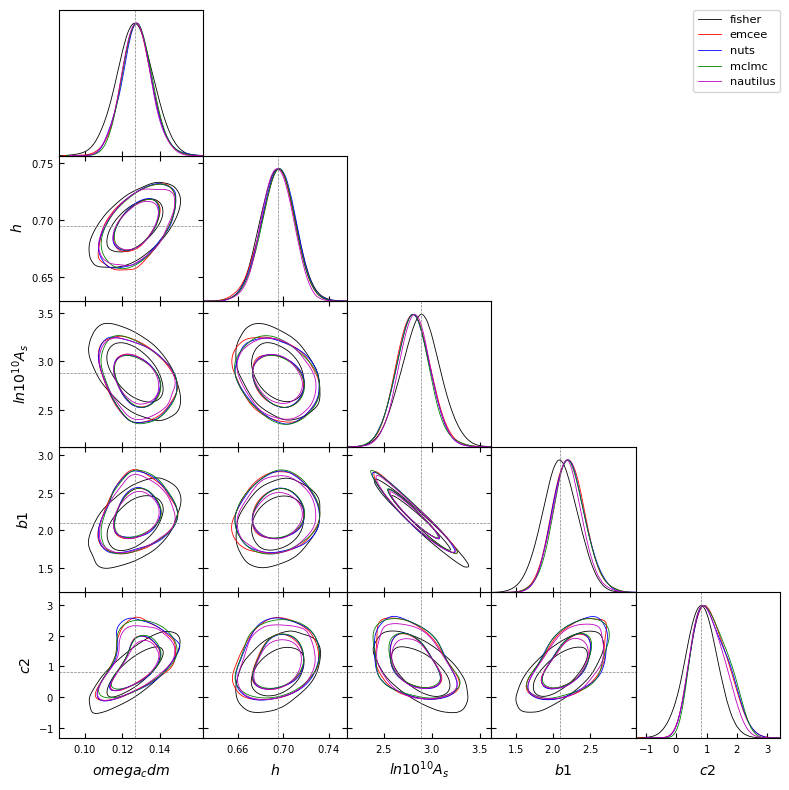


Triangle plot created successfully!


In [13]:
# Create triangle plot comparing all samplers
%matplotlib inline 
print("**Creating Triangle Plot...**")

g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot(
    [s for s in samples.values()],
    results['mclmc']['free parameters'],
    filled=False,
    markers=results['minuit']['bestfit'],
    legend_labels=[l for l in samples.keys()],
    legend_loc="upper right",
    
)

plt.tight_layout()
plt.show()

print("\nTriangle plot created successfully!")
